# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm, trange
import numpy as np
import pickle
import itertools
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

# b. MNIST Data Loader

In [82]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 256
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. DDPM**


# a. Building Blocks

In [83]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels == out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        if self.same_channels:
            out = x + x2
        else:
            out = x1 + x2
        return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask, print_shape=False):
        if print_shape:
            print("x", x.shape)
            print("c", c.shape)
            print("t", t.shape)
            print("context_mask", context_mask.shape)
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = -1 * (1 - context_mask)  # need to flip 0 <-> 1
        c = c * context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        if print_shape:
            names = ["x", "c", "down1", "down2", "hiddenvec", "context_mask", "cemb1", "temb1", "cemb2", "temb2", "up1", "up2", "up3", "out"] # fmt:skip
            for v in names:
                print(v, eval(v).shape)
        return out


with torch.no_grad():
    n_T = 400
    n_feat = 128
    lr = 1e-4
    ws_test = [0.0, 0.5, 2.0]
    context_mask = torch.zeros(256, dtype=torch.float)
    context_mask[128:] = 1.0

    cu = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10).to(device)
    t = torch.arange(1, 257, 1, dtype=torch.float)
    for x, c in train_loader:
        cu(x.to(device), c.to(device), t.to(device), context_mask.to(device), print_shape=True)
        break

x torch.Size([256, 1, 28, 28])
c torch.Size([256])
t torch.Size([256])
context_mask torch.Size([256])
x torch.Size([256, 128, 28, 28])
c torch.Size([256, 10])
down1 torch.Size([256, 128, 14, 14])
down2 torch.Size([256, 256, 7, 7])
hiddenvec torch.Size([256, 256, 1, 1])
context_mask torch.Size([256, 10])
cemb1 torch.Size([256, 256, 1, 1])
temb1 torch.Size([256, 256, 1, 1])
cemb2 torch.Size([256, 128, 1, 1])
temb2 torch.Size([256, 128, 1, 1])
up1 torch.Size([256, 256, 7, 7])
up2 torch.Size([256, 128, 14, 14])
up3 torch.Size([256, 128, 28, 28])
out torch.Size([256, 1, 28, 28])


# b. DDPM Schedules

In [84]:
def ddpm_schedules(beta1, beta2, T):
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    alpha_t = 0.0
    oneover_sqrta = 0.0
    sqrt_beta_t = 0.0
    alphabar_t = 0.0
    sqrtab = 0.0
    sqrtmab = 0.0
    mab_over_sqrtmab_inv = 0.0
    ##################
    ### Problem 1 (a): Implement ddpm_schedules()
    ##################
    ##################
    t = torch.arange(0, T, dtype=torch.float)
    beta_t = beta1 + t * (beta2 - beta1) / (T - 1)
    alpha_t = 1 - beta_t
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrt_beta_t = torch.sqrt(beta_t)
    alphabar_t = torch.cumprod(alpha_t, dim=0)
    sqrtab = torch.sqrt(alphabar_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }
a = ddpm_schedules(1e-4, 0.02, 401)
for k, v in a.items():
    print(f"{k}: {v[::50]}")

alpha_t: tensor([0.9999, 0.9974, 0.9949, 0.9924, 0.9900, 0.9875, 0.9850, 0.9825, 0.9800])
oneover_sqrta: tensor([1.0001, 1.0013, 1.0025, 1.0038, 1.0051, 1.0063, 1.0076, 1.0089, 1.0102])
sqrt_beta_t: tensor([0.0100, 0.0509, 0.0712, 0.0870, 0.1002, 0.1120, 0.1226, 0.1323, 0.1414])
alphabar_t: tensor([0.9999, 0.9337, 0.7697, 0.5599, 0.3593, 0.2034, 0.1015, 0.0446, 0.0173])
sqrtab: tensor([0.9999, 0.9663, 0.8773, 0.7483, 0.5994, 0.4510, 0.3186, 0.2113, 0.1315])
sqrtmab: tensor([0.0100, 0.2575, 0.4799, 0.6634, 0.8004, 0.8925, 0.9479, 0.9774, 0.9913])
mab_over_sqrtmab: tensor([0.0100, 0.0100, 0.0106, 0.0114, 0.0126, 0.0140, 0.0159, 0.0179, 0.0202])


# c. DDPM Main Module



In [96]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model: ContextUnet = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        ##################
        ### Problem 1 (b): Implement ddpm_schedules()
        ##################
        ##################

        t = torch.randint(self.n_T, (x.shape[0],)) + 1
        t = t - 1  # for indexing from 0
        t = t.to(self.device)
        epsilon = torch.randn(x.shape).to(device)
        alphabar_t = (
            self.alphabar_t[t]
            .view(-1, 1, 1, 1)
            .repeat(1, x.shape[1], x.shape[2], x.shape[3])
        )
        xt = torch.sqrt(alphabar_t) * x + torch.sqrt(1 - alphabar_t) * epsilon
        context_mask = torch.tensor([self.drop_prob] * x.size()[0]).to(device)
        context_mask = torch.bernoulli(context_mask).to(device)
        epsilon_theta = self.nn_model(xt, c, t.float(), context_mask)
        return self.loss_mse(epsilon_theta, epsilon)

    def sample(self, n_sample, size, device, guide_w=0.0, max_t=None, return_all=False):
        """
        guide_w: classifier-free guidance weight (Classifier-Free Diffusion Guidance, arXiv:2207.12598)
        """
        x_i = torch.randn(n_sample, *size).to(device)
        c_i = torch.arange(0, 10).to(device)
        if n_sample > 10:
            c_i = c_i.repeat(n_sample // c_i.shape[0])
        else:
            c_i = c_i[:n_sample]

        context_mask = torch.zeros_like(c_i).to(device)

        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # second half context-free
        if return_all:
            x_is = [x_i]

        if max_t is None:
            max_t = self.n_T
        for i in trange(max_t, 0, -1):
            i = i - 1  # for indexing from 0
            if i > 1:
                sigma = (
                    torch.sqrt(self.sqrtmab[i - 1] / self.sqrtmab[i])
                    * self.sqrt_beta_t[i]
                )
            else:
                sigma = 0.0
            epsilon = self.nn_model(
                x_i.repeat(2, 1, 1, 1),
                c_i,
                torch.tensor([i], device=device).float().repeat(n_sample * 2),
                context_mask,
            )

            eps1 = epsilon[:n_sample]
            eps2 = epsilon[n_sample:]
            epsilon = (1 + guide_w) * eps1 - guide_w * eps2

            mu = self.oneover_sqrta[i] * (x_i - self.mab_over_sqrtmab[i] * epsilon)
            with torch.no_grad():
                x_i = mu + sigma * torch.randn_like(x_i).to(device)
                if return_all:
                    x_is.append(x_i)
            del epsilon, mu, sigma

            ##################
            ### Problem 1 (b): Implement ddpm_schedules()
            ##################
            ##################
        if return_all:
            return x_is
        return x_i

    def plot_noisying(self, x, n_T, plot_dt=1):
        x = x.to(self.device)
        x_original = x.clone()
        epsilon = torch.randn(n_T, *x.shape[-2:]).to(self.device)
        fig, axes = plt.subplots(n_T // plot_dt // 10, 10, figsize=(10, 6))
        axes = iter(axes.flatten())
        for t in range(1, n_T + 1):
            t = t - 1  # for indexing from 0
            x_noisy = (
                torch.sqrt(self.alphabar_t[t]) * x_original
                + torch.sqrt(1 - self.alphabar_t[t]) * epsilon[t]
            )
            if t % plot_dt == 0:
                ax = next(axes)
                ax.imshow(x_noisy[0, 0].cpu(), cmap="gray")
                ax.set_title(f"t={t}")
                ax.axis("off")
        fig.tight_layout()
        plt.show()

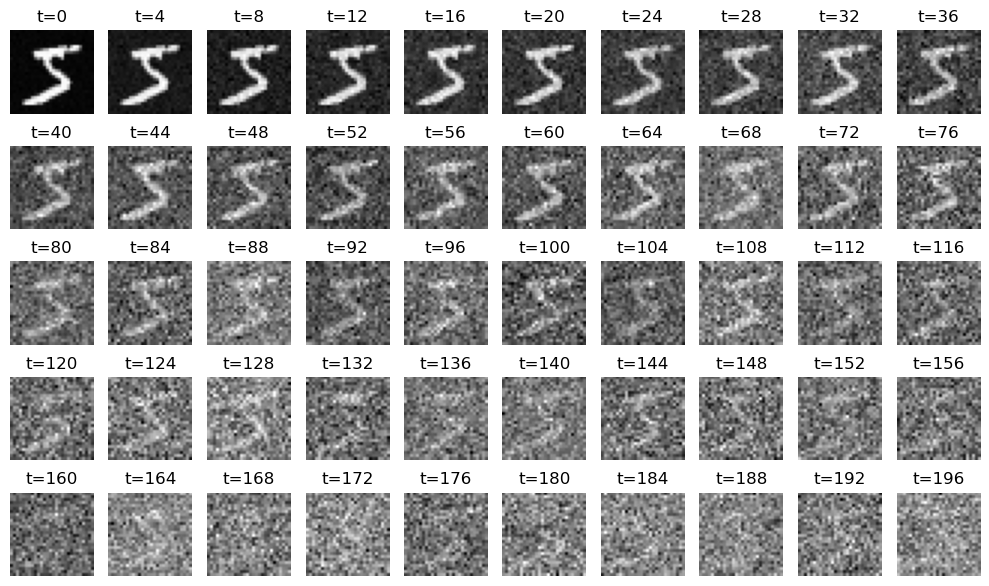

In [86]:
n_T = 400
n_feat = 128

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm = ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

with torch.no_grad():
    ddpm.plot_noisying(train_dataset[0][0][None], 200, plot_dt=4)

# c. Training Function

In [ ]:
def train_main_loop(ddpm, optim, dataloader, lr, ws_test, n_epoch, batch_size):
    for ep in range(n_epoch):
        print(f"epoch {ep}")
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]["lr"] = lr * (1 - ep / n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        # train
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        # eval
        ddpm.eval()
        with torch.no_grad():
            n_sample = 20
            for w_i, w in enumerate(ws_test):
                x_gen = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                fig, axes = plt.subplots(2, 10, figsize=(10, 2))
                for i, j in itertools.product(range(2), range(10)):
                    axes[i, j].get_xaxis().set_visible(False)
                    axes[i, j].get_yaxis().set_visible(False)

                axes = iter(axes.flatten())
                for k in range(n_sample):
                    ax = next(axes)
                    ax.cla()
                    ax.imshow(
                        x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys"
                    )
                fig.suptitle(f"guide_w={w}")
                plt.show()

        # if ep == n_epoch - 1:
        #   plt.savefig('final_generated_samples.png', bbox_inches='tight')


def test_result(ddpm, max_t=None, ws=[0.0, 0.5, 2.0]):
    ddpm.eval()
    with torch.no_grad():
        for w in ws:
            print(f"w={w}")
            n_sample = 20
            x_gen = ddpm.sample(n_sample, (1, 28, 28), device, max_t=max_t, guide_w=w)

            fig, axes = plt.subplots(2, 10, figsize=(10, 2))
            for i, j in itertools.product(range(2), range(10)):
                axes[i, j].get_xaxis().set_visible(False)
                axes[i, j].get_yaxis().set_visible(False)

            axes = iter(axes.flatten())
            for k in range(n_sample):
                ax = next(axes)
                ax.cla()
                ax.imshow(x_gen[k, :].data.cpu().numpy().reshape(28, 28), cmap="Greys")
            plt.show()

            n_sample = 1
            x_gens = ddpm.sample(
                n_sample, (1, 28, 28), device, return_all=True, guide_w=w
            )
            x_gens = x_gens[::-1]

            fig, axes = plt.subplots(4, 10, figsize=(10, 4))
            axes = axes.flatten()
            axes = iter(axes)
            for t in range(len(x_gens) - 10, 0, -10):
                ax = next(axes)
                ax.cla()
                ax.set_title(f"t={t-1}")
                ax.imshow(
                    x_gens[t - 1][0].data.cpu().numpy().reshape(28, 28), cmap="Greys"
                )
                ax.axis("off")
            fig.tight_layout()
            plt.show()

# e. Training


In [ ]:
# hardcoding these here
n_epoch = 1
n_T = 400
n_feat = 128
lr = 1e-4
ws_test = [0.0, 0.5, 2.0]

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1).to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
# train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)
ddpm.load_state_dict(torch.load('./models/DDPM_epoch=100.pt'))

<All keys matched successfully>

w=0.0


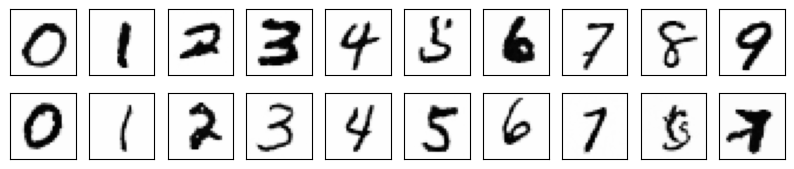

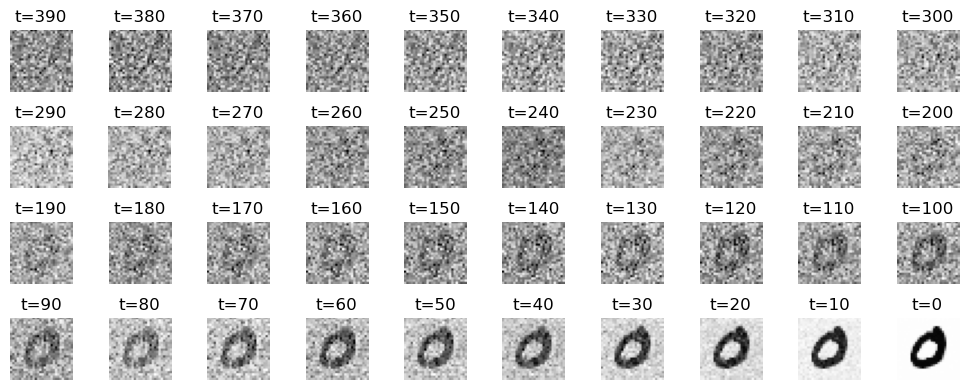

w=0.5


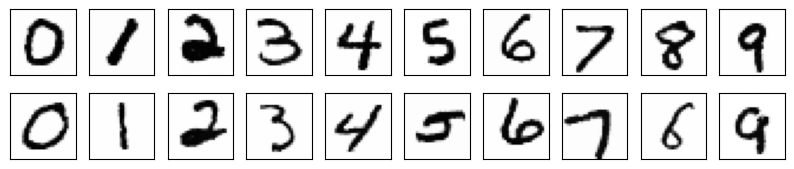

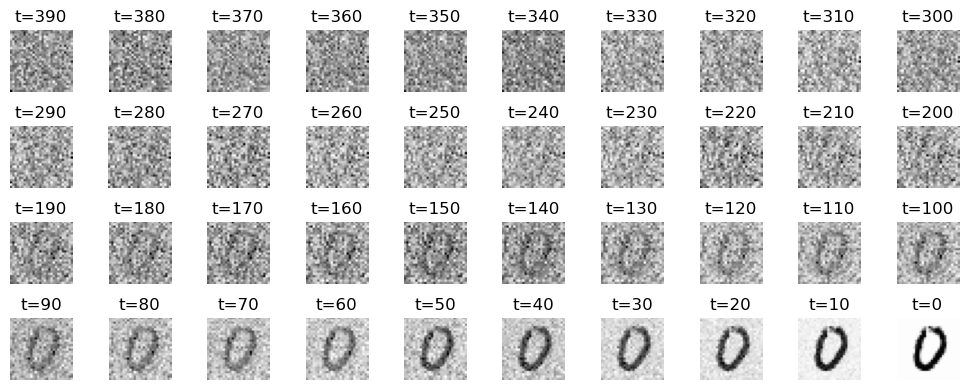

w=2.0


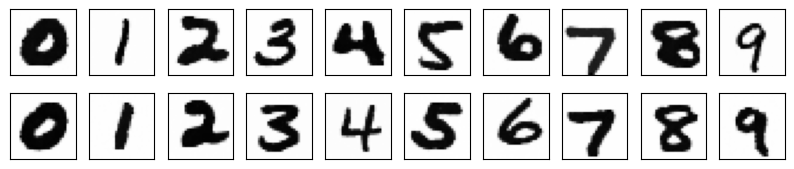

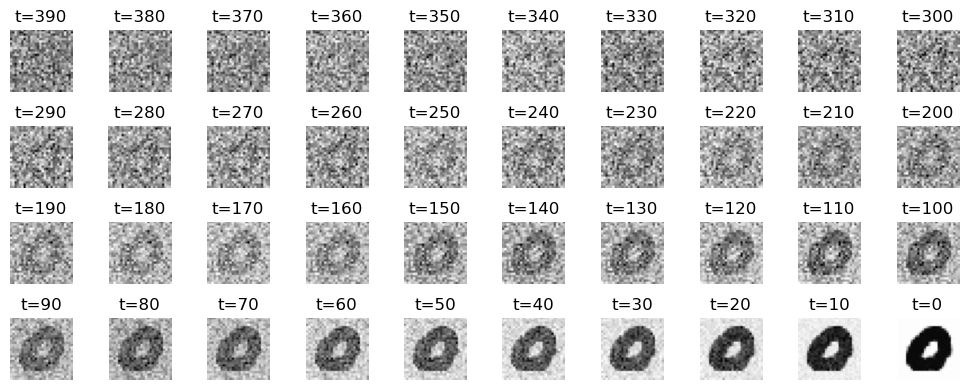

In [93]:
test_result(ddpm)

w=0.0


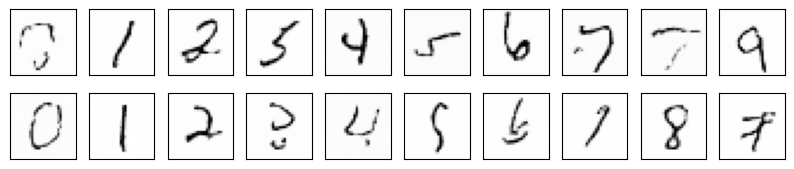

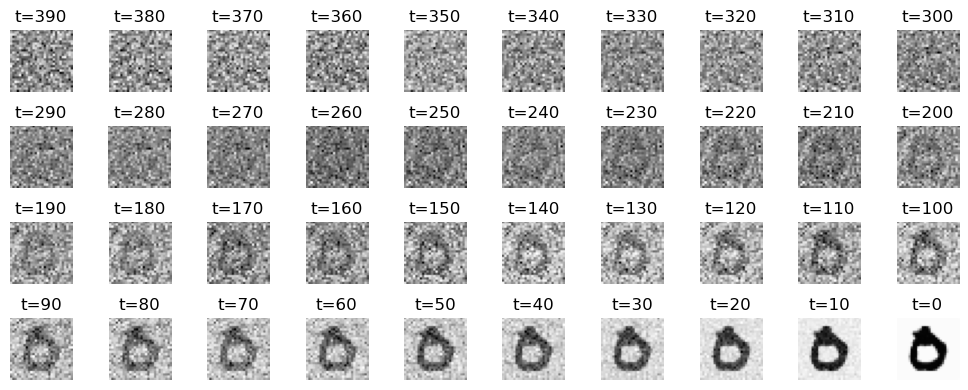

w=0.5


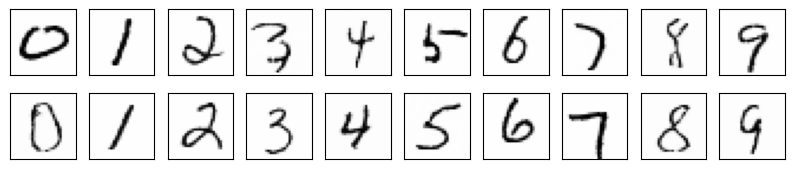

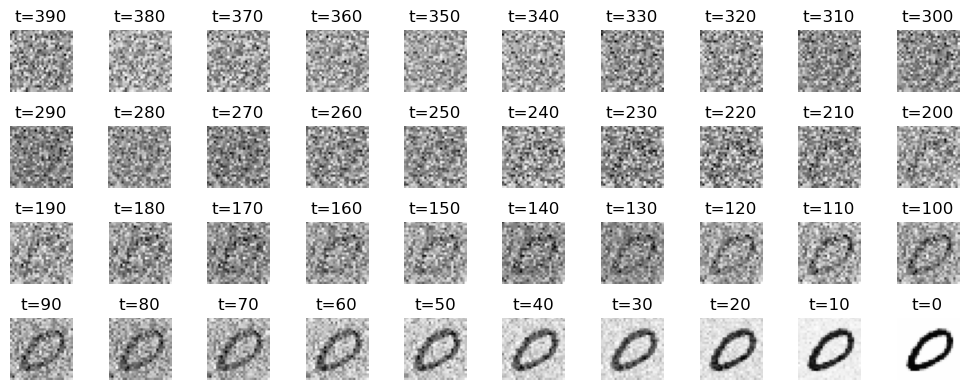

w=2.0


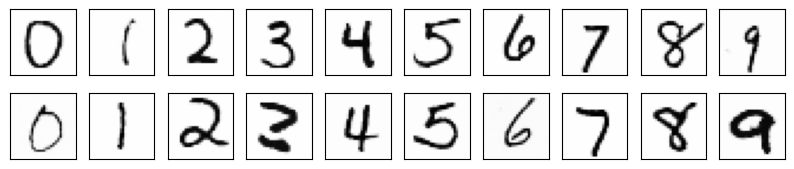

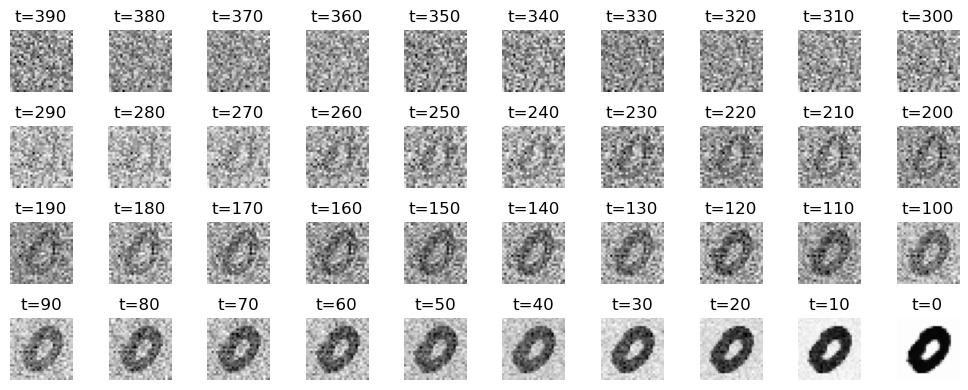

In [95]:
test_result(ddpm, max_t=ddpm.n_T//2)

w=0.0


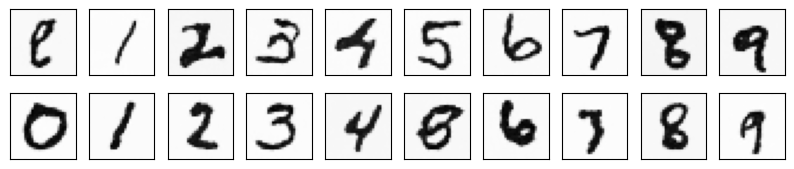

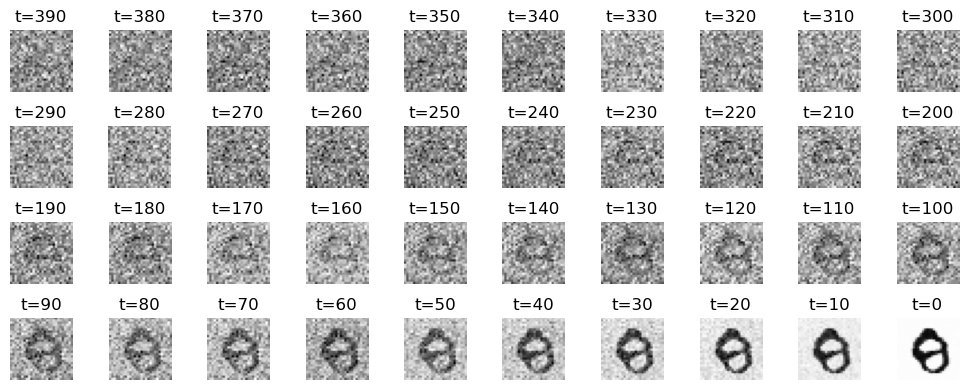

w=0.5


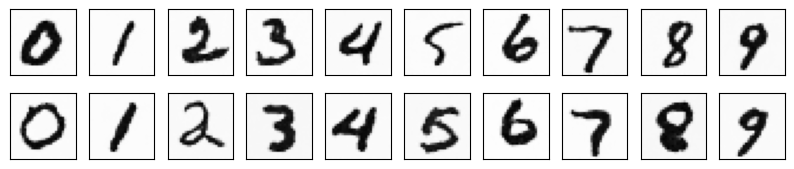

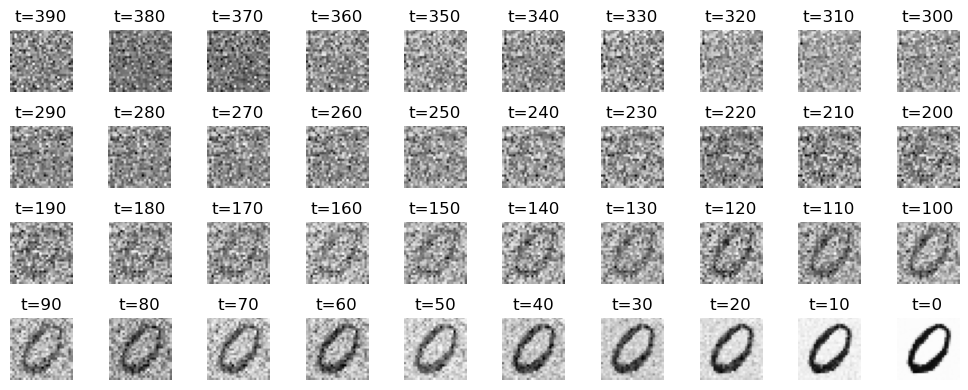

w=2.0


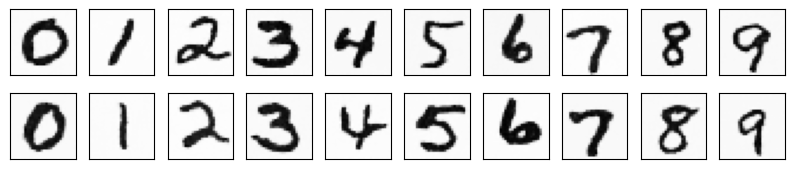

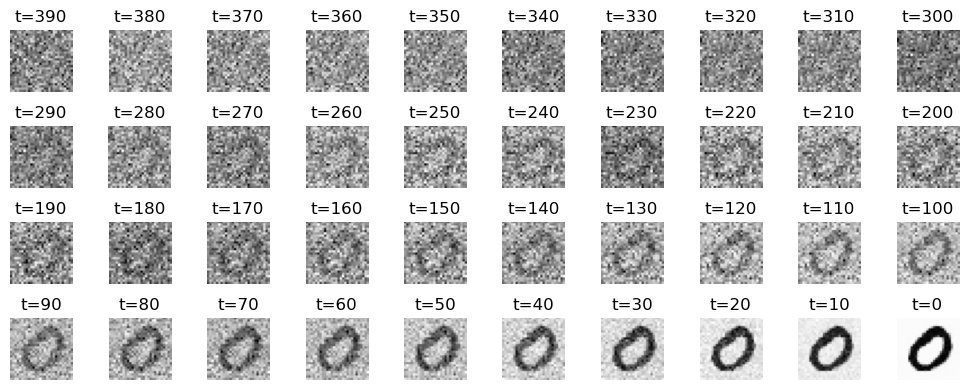

In [100]:
ddpm.load_state_dict(torch.load('./models/DDPM_guidance_epoch=20.pt'))
test_result(ddpm)

# **2. Ablation Study**

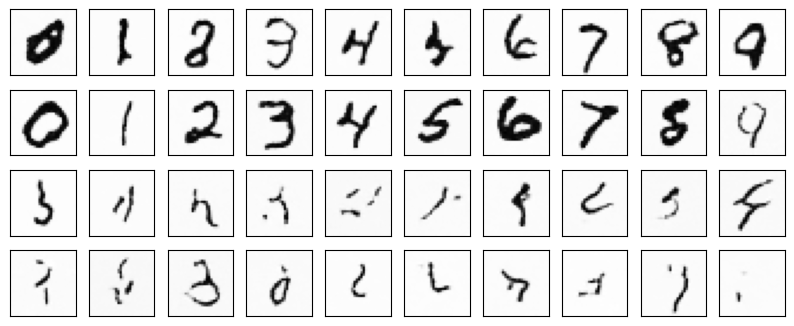

StopIteration: 

In [14]:
##################
### Problem 2: Ablation Study
##################

n_T = 2000
n_feat = 128

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1).to(device)

ddpm.load_state_dict(torch.load('./models/DDPM_n_T=2000_epoch=60.pt'))
test_result(ddpm)

# **3. Continuous-time Stochastic Process**

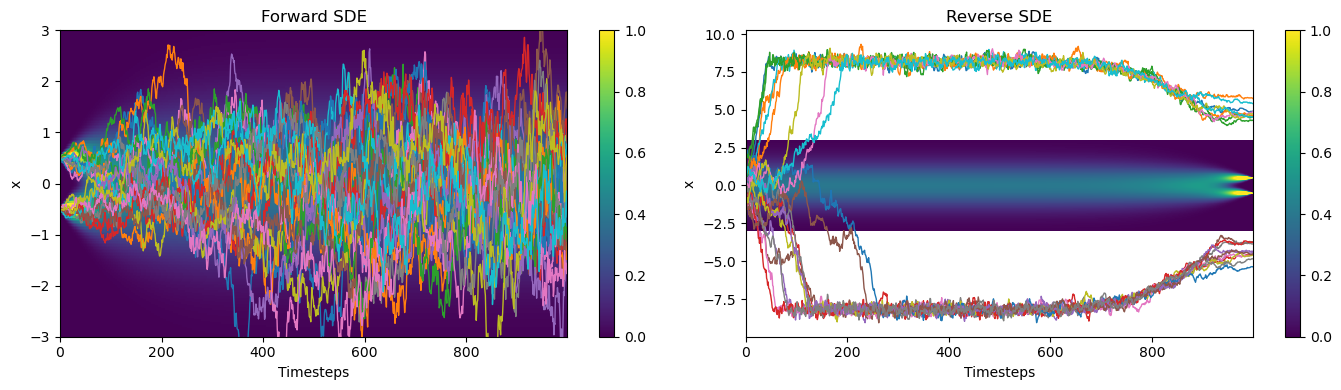

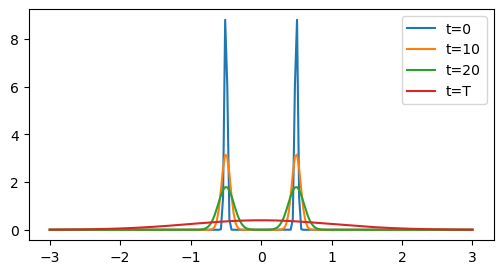

In [68]:
timesteps = 1000
beta1 = 0.1
beta2 = 50.0
dt = 1.0 / timesteps
means = np.array([0.5, -0.5])
stds = np.array([0.02, 0.02])
stds = np.array([0.02, 0.02])
weights = np.array([0.5, 0.5])
# means = np.array([0.5])
# stds = np.array([0.02])
# weights = np.array([0.5])
weights /= np.sum(weights)
n_samples = 20
x_min = -3
x_max = 3
x_grid = np.linspace(x_min, x_max, num=201)


def get_beta_t(t):
    ratio = float(t) / timesteps
    return ratio * beta2 + (1 - ratio) * beta1


def f(x, t):
    beta_t = get_beta_t(t)
    return -0.5 * beta_t * x


def g(t):
    beta_t = get_beta_t(t)
    return np.sqrt(beta_t)


def gaussian_pdf(x, mean, std):
    return (1.0 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)


def mixture_pdf(x):
    pdf = np.zeros_like(x)
    for i in range(len(means)):
        pdf += weights[i] * gaussian_pdf(x, means[i], stds[i])
    return pdf


def sample_mixture_gaussian(n_samples):
    components = np.random.choice(
        len(means), size=n_samples, p=weights / np.sum(weights)
    )
    samples = np.random.normal(loc=means[components], scale=stds[components])
    return samples


def p_xt_old(x_t, t, return_all=False):
    p_xt_val = np.zeros_like(x_t)
    ##################
    ### Problem 3(a): p(x(t))
    ##################
    ##################
    x_t = x_t[:, None]  # (n_samples, len(weights))
    A = np.exp(-(t**2 * dt * (beta2 - beta1) / (2 * timesteps) + t * dt * beta1))
    D = stds**2 * A + 1 - A
    B = (stds**2 * x_t * np.sqrt(A) + (1 - A) * means) / D
    C = (stds**2 * x_t**2 + (1 - A) * means**2) / (D) - B**2

    p_xt_val = np.sum(
        weights * np.exp(-C * D / (2 * (1 - A) * stds**2)) / np.sqrt(2 * np.pi * D),
        axis=1,
    )
    if return_all:
        return p_xt_val, A, B, C, D
    return p_xt_val


def grad_log_p_xt_old(x_t, t):
    ##################
    ### Problem 3(b): \nabla_x(t) \log p(x(t))
    ##################
    ##################
    p_xt_val, A, B, C, D = p_xt_old(x_t, t, return_all=True)
    x_t = x_t[:, None]  # (n_samples, len(weights))

    dp_dx = np.sum(
        weights
        * np.exp(-C * D / (2 * (1 - A) * stds**2))
        / np.sqrt(2 * np.pi * D)
        * (-D / (2 * (1 - A) * stds**2))
        * ((2 * stds**2 * x_t / D) - (2 * B * stds**2 * np.sqrt(A) / D)),
        axis=1,
    )
    return dp_dx / (p_xt_val + 1e-15)


def p_xt(x_t, t, return_all=False):
    p_xt_val = np.zeros_like(x_t)
    ##################
    ### Problem 3(a): p(x(t))
    ##################
    ##################
    x_t = x_t[:, None]  # (n_samples, len(weights))
    A = np.exp(-(t**2 * dt * (beta2 - beta1) / (2 * timesteps) + t * dt * beta1))
    D = stds**2 * A + 1 - A

    mu = np.sqrt(A) * means
    sigma_square = D
    p_xt_val = (
        weights
        / np.sqrt(2 * np.pi * sigma_square)
        * np.exp(-((x_t - mu) ** 2) / (2 * sigma_square))
    )
    p_xt_val_before_sum = p_xt_val
    p_xt_val = np.sum(p_xt_val, axis=1)
    if return_all:
        return p_xt_val, p_xt_val_before_sum, mu, sigma_square
    return p_xt_val


def grad_log_p_xt(x_t, t):
    ##################
    ### Problem 3(b): \nabla_x(t) \log p(x(t))
    ##################
    ##################
    p_xt_val, p_xt_val_before_sum, mu, sigma_square = p_xt(x_t, t, return_all=True)
    x_t = x_t[:, None]  # (n_samples, len(weights))
    dp_dx = p_xt_val_before_sum * (-2 * (x_t - mu) / (2 * sigma_square))
    dp_dx = np.sum(dp_dx, axis=1)
    return dp_dx / (p_xt_val + 1e-15)


# def p_xt(x_t, t):
#     p_xt_val = np.zeros_like(x_t)
#     ##################
#     ### Problem 3(a): p(x(t))
#     ##################
#     ##################

#     std_xt_x0 = np.sqrt(beta1**2 * (beta2 / beta1) ** (2 * t / timesteps))

#     p_xt_val = np.zeros_like(x_t)
#     for i in range(len(means)):
#         # betat = get_beta_t(t)
#         p_xt_val += weights[i] * gaussian_pdf(
#             x_t, means[i], np.sqrt(stds[i] ** 2 + std_xt_x0**2)
#         )

#     return p_xt_val


# def grad_log_p_xt(x_t, t):
#     ##################
#     ### Problem 3(b): \nabla_x(t) \log p(x(t))
#     ##################
#     ##################

#     grad = 0.0
#     std_xt_x0 = np.sqrt(beta1**2 * (beta2 / beta1) ** (2 * t / timesteps))
#     p_xt_val = p_xt(x_t, t)
#     for i in range(len(means)):
#         sgi = np.sqrt(stds[i] ** 2 + std_xt_x0**2)
#         grad += (
#             1
#             / (p_xt_val + 1e-15)
#             * (
#                 weights[i]
#                 * gaussian_pdf(x_t, means[i], sgi)
#                 * (-(x_t - means[i]) / sgi**2)
#             )
#         )
#     return grad


def forward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))

    x_pdf = np.zeros((timesteps, x_grid.shape[0]))

    x0 = sample_mixture_gaussian(n_samples)
    x0_pdf = mixture_pdf(x_grid)
    x[0] = x0
    x_pdf[0] = x0_pdf

    for t in range(1, timesteps):
        noise = np.random.normal(0, 1, size=n_samples)
        x[t] = x[t - 1] + f(x[t - 1], t) * dt + g(t) * noise * np.sqrt(dt)
        x_pdf[t] = p_xt(x_grid, t)

    return x, x_pdf


def backward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))
    xT = np.random.normal(0, 1, size=n_samples)
    x[-1] = xT

    for t in range(timesteps - 1, 0, -1):
        noise = np.random.normal(0, 1, size=n_samples)
        delta_x = (f(x[t], t) - g(t) ** 2 * grad_log_p_xt(x[t], t)) * dt + g(
            t
        ) * noise * np.sqrt(dt)
        x[t - 1] = x[t] + delta_x

    return x


# np.testing.assert_allclose(p_xt(x_grid, 2), p_xt_old(x_grid, 2), rtol=0, atol=1e-8)
# np.testing.assert_allclose(
#     grad_log_p_xt(x_grid, 2), grad_log_p_xt_old(x_grid, 2), rtol=0, atol=1e-8
# )

forward_x, forward_x_pdf = forward_sde(timesteps, n_samples, dt)
backward_data = backward_sde(timesteps, n_samples, dt)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for i in range(n_samples):
    axes[0].plot(forward_x[:, i], lw=1)

time = np.arange(timesteps)
X, Y = np.meshgrid(time, x_grid)
pcm = axes[0].pcolormesh(
    X,
    Y,
    forward_x_pdf.T,
    cmap="viridis",
    shading="auto",
    vmin=0,
    vmax=1,
    # norm=LogNorm(vmin=1e-5, vmax=1),
)
axes[0].set_title("Forward SDE")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("x")
axes[0].set_ylim([x_min, x_max])
plt.colorbar(pcm)

for i in range(n_samples):
    axes[1].plot(backward_data[::-1][:, i], lw=1)

X, Y = np.meshgrid(time, x_grid)
pcm = axes[1].pcolormesh(
    X,
    Y,
    forward_x_pdf[::-1].T,
    cmap="viridis",
    shading="auto",
    vmin=0,
    vmax=1,
)
axes[1].set_title("Reverse SDE")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("x")
plt.colorbar(pcm)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(6, 3))
axes.plot(x_grid, forward_x_pdf[0], label="t=0")
axes.plot(x_grid, forward_x_pdf[10], label="t=10")
axes.plot(x_grid, forward_x_pdf[20], label="t=20")
axes.plot(x_grid, forward_x_pdf[-1], label="t=T")
axes.legend()
plt.show()